In [5]:
import tensorflow as tf
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [50]:
""" transfer dataset to tfrecord method"""
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian
offset_table=open("mnist-sparse_padded-offset_table",'wb') 

with tf.io.TFRecordWriter("mnist_sparse_padded.tfrecords") as writer:
    # page size=4KB, padding to write to another page if the next instance exceeds the page
    
    """padding needs to ne slightly modified: because padded record needs at least 16B, 
    instead of see if after_ptr exceeds, see if after_ptr+16 exceeds """
    
    cur_page=0
    for i in range (60000):
        # current tfr file ptr = current_filesize
        with open(images_dir+str(i)+'.jpg','rb') as f:
            buf=mnist_labels.read(1)
            _label=buf
            img_bytes=f.read()            
            
            current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords")
            # test if exceeds or not, other 3 columns: 16B
            cur_page=int(current_filesize/4096)
            serialized_example = serialize_example(_label, img_bytes)
            calc_new_filesize=current_filesize+len(serialized_example)+16+16
            calc_new_page=int(calc_new_filesize/4096)            
            
            if(calc_new_page>cur_page):
                # if exceeds: padding until reaching new page
                #TODO: the pad still needs 16B metadata
                pad_len=calc_new_page*4096-current_filesize
                #print("before pad:",current_filesize)
                pad=b''
                if(pad_len-16>0):                    
                    for _ in range (pad_len-16):
                        pad+=b'0'
                    #print("len(pad)=",len(pad))
                    writer.write(pad)
                    #current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
                    #print("after pad",current_filesize)
                else:
                    print("error")
            current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
            if(i%4000==0):
                print(i,end=' ')
                print("offset=",current_filesize)
            if(i>59300):
                print(i)
            offset_table.write(current_filesize.to_bytes(8, byteorder = 'little')) 
            writer.write(serialized_example)
offset_table.close()

0 offset= 0
4000 offset= 2720357
8000 offset= 5440147
12000 offset= 8161859
16000 offset= 10880771
20000 offset= 13597054
24000 offset= 16320380
28000 offset= 19037277
32000 offset= 21751540
36000 offset= 24468494
40000 offset= 27184230
44000 offset= 29902677
48000 offset= 32623537
52000 offset= 35341560
56000 offset= 38058426
59301
59302
59303
59304
59305
59306
59307
59308
59309
59310
59311
59312
59313
59314
59315
59316
59317
59318
59319
59320
59321
59322
59323
59324
59325
59326
59327
59328
59329
59330
59331
59332
59333
59334
59335
59336
59337
59338
59339
59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412

In [ ]:
""" standard way to iterate tfr, to make sure the tfr format is right """

dataset = tf.data.TFRecordDataset('mnist_sparse.tfrecords')

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    # var len is different
    'image': tf.io.FixedLenFeature([],tf.string),
}

def _parse_function(example_proto):
    serialized_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return serialized_example


for idx, features in enumerate(dataset):
    parsed_features = _parse_function(features)
    print("label=",parsed_features['label'].numpy())    
    image=tf.io.decode_jpeg(parsed_features['image'])
    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
    plt.show()
    
    if idx>=11:
        break

In [51]:
"""offset table read test"""

oft=open("mnist-sparse_padded-offset_table",'rb')
idx=5
for i in range (60000):
    
    tmp=oft.read(8)
    #print(tmp)
    if(i>54000):
        length=struct.unpack("<Q",tmp)
        print(length[0])

36697350
36697966
36698657
36699304
36700160
36700697
36701299
36701858
36702476
36703088
36704256
36704962
36705640
36706267
36706933
36707540
36708352
36708974
36709544
36710088
36710769
36711354
36712448
36713003
36713758
36714402
36715039
36715577
36716544
36717163
36717817
36718454
36719022
36719657
36720640
36721302
36721870
36722535
36723185
36723802
36724736
36725359
36726032
36726641
36727317
36727941
36728832
36729472
36730115
36730727
36731327
36731946
36732928
36733558
36734168
36734807
36735503
36736152
36737024
36737581
36738180
36738733
36739315
36739918
36741120
36741790
36742325
36742884
36743576
36744181
36745216
36745756
36746368
36747011
36747656
36748300
36749312
36749936
36750539
36751091
36751726
36752387
36753408
36754033
36754654
36755314
36755869
36756407
36757504
36758141
36758746
36759313
36760004
36760605
36761600
36762227
36762818
36763450
36764097
36764748
36765696
36766365
36767019
36767566
36768152
36768798
36769792
36770407
36771080
36771689
36772282
3

38644729
38645760
38646312
38646822
38647479
38648076
38648739
38649856
38650352
38651002
38651657
38652277
38652856
38653952
38654593
38655244
38655827
38656468
38657055
38658048
38658582
38659197
38659846
38660449
38661063
38662144
38662784
38663414
38663999
38664691
38665315
38666240
38666927
38667543
38668170
38668791
38669381
38670336
38670924
38671525
38672054
38672570
38673168
38674432
38675051
38675696
38676375
38676995
38677515
38678528
38679067
38679750
38680353
38680964
38681544
38682624
38683208
38683816
38684459
38685083
38685698
38686720
38687341
38687943
38688573
38689211
38689818
38690816
38691454
38692067
38692635
38693297
38693882
38694912
38695545
38696119
38696750
38697284
38697869
38699008
38699703
38700268
38700876
38701413
38702007
38703104
38703716
38704389
38705087
38705734
38706358
38707200
38707843
38708365
38709050
38709699
38710313
38711296
38711798
38712400
38712990
38713572
38714138
38714684
38715392
38716056
38716707
38717375
38717957
38718528
38719488
3

40538112
40538740
40539356
40539981
40540608
40541291
40542208
40542803
40543443
40544104
40544790
40545364
40546304
40546904
40547487
40548055
40548690
40549354
40550400
40551016
40551626
40552266
40552960
40553569
40554496
40555156
40555782
40556423
40557043
40557662
40558592
40559286
40559907
40560561
40561175
40561813
40562688
40563352
40563999
40564549
40565163
40565694
40566784
40567405
40568068
40568618
40569266
40569793
40570880
40571514
40572071
40572706
40573355
40573925
40574976
40575575
40576194
40576870
40577395
40578031
40579072
40579658
40580250
40580847
40581431
40582087
40583168
40583790
40584406
40585009
40585620
40586214
40587264
40587907
40588579
40589141
40589749
40590345
40591360
40591989
40592614
40593162
40593799
40594428
40595456
40596105
40596726
40597278
40597907
40598516
40599552
40600079
40600663
40601270
40601894
40602608
40603648
40604244
40604835
40605441
40606060
40606684
40607744
40608314
40608928
40609535
40610091
40610682
40611840
40612440
40613102
4

In [44]:
""" the actual read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

offset= 40710144
length= 552
tf.Tensor(b'\x04', shape=(), dtype=string)


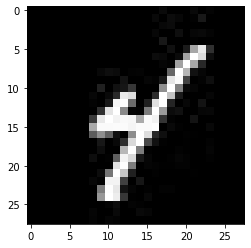

In [53]:
""" test read() function """

binfile=open('mnist_sparse_padded.tfrecords','rb')
oftfile=open('mnist-sparse_padded-offset_table','rb')
parsed_feature=sparse_random_read(binfile,oftfile, 59900)
image=tf.io.decode_jpeg(parsed_feature['image'])
print(parsed_feature['label'])
np_image=np.frombuffer(image, dtype='>B').astype(np.uint8)
plt.imshow(np.asarray(np_image).reshape((28,28)),cmap = plt.cm.gray)                                        
plt.show()